# Estimate envelop correlations in source space

In [1]:
import os
import sys
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Settings

In [2]:
# The subject
subject_name = 'MEG_S02'

# Data folders
stc_folder = os.path.join('MiddleResults', 'SourceEstimation')
raw_folder = os.path.join('_link_preprocessed', subject_name)

# The subject being morph to
subject_to = 'fsaverage'

def freesurfer_trans(subject_name):
    '''
    Generate freesurfer name based on [subject_name]
    - @subject_name: subject name in MEG data, like 'MEG_S02'
    '''
    assert(subject_name.startswith('MEG'))
    return subject_name.replace('MEG', 'RSVP_MRI')

freesurfer_name = freesurfer_trans(subject_name)

mne.utils.set_config('SUBJECTS_DIR',
                     os.path.join('_link_freesurfer', 'subjects'))

## Read epochs

In [3]:
epochs_inventory = pd.read_json('inventory-epo.json')

def fetch_subject(subject, frame=epochs_inventory):
    return frame.query(f'subject == "{subject}"')

epochs_list = [mne.read_epochs(e) for e in
               fetch_subject(subject_name)['epochsPath'].tolist()]
epochs = mne.concatenate_epochs(epochs_list)
epochs.apply_baseline((None, 0))
epochs = epochs['1']
epochs

Reading _link_epochs/MEG_S02/block_03-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1200.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Reading _link_epochs/MEG_S02/block_04-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1200.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1448 matching events found
No baseline correction applied
0 projection items activated
Reading _link_epochs/MEG_S02/block_05-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1200.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1442 matching events found
No baseline correction applied
0 projection items activated
Reading _link_epochs/MEG_S02/block_06-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...

<Epochs |  465 events (all good), -0.2 - 1.2 sec, baseline [-0.2, 0] sec, ~136.3 MB, data loaded,
 '1': 465>

## Read stuff of source estimation

In [4]:
# Prepares
cls_table = {
    'bem-sol': mne.read_bem_solution,
    'bem': mne.read_bem_surfaces,
    'src': mne.read_source_spaces,
    'trans': mne.read_trans
}

def get_stuff(cls_name, subject=subject_name, folder=raw_folder, table=cls_table):
    '''
    Read the file of [cls_name] based on [cls_table] for the [subject] in [folder]
    - @cls_name: The latest of the .fif file
    - @subject: Subject name, like 'MEG_S02'
    - @folder: The folder of raw files, it should contain target files
    - @table: The table of source stuff
    '''
    # Legal assertion
    assert(cls_name in table)
    assert(subject.startswith('MEG'))

    # Load correct reader
    reader = table[cls_name]

    # Generated .fif file name
    fname = f'{freesurfer_name}-{cls_name}.fif'
    path = os.path.join(folder, fname)

    # Read the stuff and return it
    obj = reader(path)
    print(f'Got {cls_name} from {path}')
    return obj

src=get_stuff('src')
model=get_stuff('bem')
sol=get_stuff('bem-sol')
trans=get_stuff('trans')

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Got src from _link_preprocessed/MEG_S02/RSVP_MRI_S02-src.fif
    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Got bem from _link_preprocessed/MEG_S02/RSVP_MRI_S02-bem.fif
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear_collocation BEM solution from _link_preprocessed/MEG_S02/RSVP_MRI_S02-bem-sol.fif
Got bem-sol from _link_preprocessed/MEG_S02/RSVP_MRI_S02-bem-sol.fif
Got trans from _link_preprocessed/MEG_S02/RSVP_MRI_S02-trans.fif


## Source estimation on epochs
stc will be generated

In [5]:
# Parameters
loose = 0.2
depth = 0.8
n_jobs = 48

# Forward solution
kwargs = dict(eeg=False,
              n_jobs=n_jobs)
fwd = mne.make_forward_solution(epochs.info, trans, src, sol, **kwargs)

# Covariance matrix
kwargs = dict(tmax=.0,
              method='empirical',
              n_jobs=n_jobs)
cov = mne.compute_covariance(epochs, **kwargs)

# Inverse operator
kwargs = dict(loose=loose,
              depth=depth)
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, **kwargs)



# Inverse computation
# Parameters
spacing = 6
lambda2 = 1/9

# Prepare epochs
# kwargs = dict(n_jobs=48)
# epochs.apply_hilbert(**kwargs)

# Source estimation
kwargs = dict(lambda2=lambda2,
              pick_ori='normal')
stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, **kwargs)
stcs

Source space          : <SourceSpaces: [<surface (lh), n_vertices=166546, n_used=4098>, <surface (rh), n_vertices=166009, n_used=4098>] MRI (surface RAS) coords, subject 'RSVP_MRI_S02', ~29.0 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.997111  0.072733 -0.021875      -2.78 mm
    -0.038459  0.731871  0.680357      -9.07 mm
     0.065495 -0.677551  0.732554      58.08 mm
     0.000000  0.000000  0.000000       1.00

Read 272 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.998888  0.040716 -0.023788       1.37 mm
    -0.026395  0.900790  0.433452      26.31 mm
     0.039077 -0.432342  0.900863      67.24 mm
     0.000000  0.000000  0.0

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:   17.7s remaining:   59.5s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:   17.7s remaining:   22.8s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:   17.9s remaining:    9.8s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:   18.0s remaining:    3.1s


    Skipping interior check for 891 sources that fit inside a sphere of radius   45.8 mm
    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:   18.4s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.1s remaining:    0.5s



Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:   11.4s remaining:   38.2s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:   11.5s remaining:   14.8s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:   11.7s remaining:    6.4s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:   11.9s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:   12.0s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.7s remaining:    2.2s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:   

Computing MEG at 8196 source locations (free orientations)...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    2.5s remaining:    8.3s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    4.1s remaining:    5.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    5.8s remaining:    3.2s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    7.5s remaining:    1.3s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    8.7s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.0s



Finished.


[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished


Computing rank from data with rank=None
    Using tolerance 6.1e-09 (2.2e-16 eps * 272 dim * 1e+05  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 projectors
Reducing data rank from 272 -> 272
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 9765
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 272 channels.
    272 out of 272 channels remain after picking
Selected 272 channels
Creating the depth weighting matrix...
    272 magnetometer or axial gradiometer channels
    limit = 5809/8196 = 10.001598
    scale = 1.24636e-09 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 6.4e-14 (2.2e-1

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=48)]: Done 132 tasks      | elapsed:    0.8s


Preparing the inverse operator for use...


[Parallel(n_jobs=48)]: Done 272 out of 272 | elapsed:    1.1s finished


    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 58 (214 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 272 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 465
Processing epoch : 2 / 465
Processing epoch : 3 / 465
Processing epoch : 4 / 465
Processing epoch : 5 / 465
Processing epoch : 6 / 465
Processing epoch : 7 / 465
Processing epoch : 8 / 465
Processing epoch : 9 / 465
Processing epoch : 10 / 465
Processing epoch : 11 / 465
Processing epoch : 12 / 465
Processing epoch : 13 / 465
Processing epoch : 14 / 465
Processing epoch : 15 / 465
Processing epoch : 16 / 465
Processing epoch : 17 / 465
Processing epoch : 18 / 465
Processing epoch : 19 / 465
Processing epoch : 20 / 465
Processing epoch : 21 / 465
Proce

[<SourceEstimate | 8196 vertices, subject : RSVP_MRI_S02, tmin : -200.0 (ms), tmax : 1200.0000000000002 (ms), tstep : 10.0 (ms), data shape : (8196, 141), ~17.7 MB>,
 <SourceEstimate | 8196 vertices, subject : RSVP_MRI_S02, tmin : -200.0 (ms), tmax : 1200.0000000000002 (ms), tstep : 10.0 (ms), data shape : (8196, 141), ~17.7 MB>,
 <SourceEstimate | 8196 vertices, subject : RSVP_MRI_S02, tmin : -200.0 (ms), tmax : 1200.0000000000002 (ms), tstep : 10.0 (ms), data shape : (8196, 141), ~17.7 MB>,
 <SourceEstimate | 8196 vertices, subject : RSVP_MRI_S02, tmin : -200.0 (ms), tmax : 1200.0000000000002 (ms), tstep : 10.0 (ms), data shape : (8196, 141), ~17.7 MB>,
 <SourceEstimate | 8196 vertices, subject : RSVP_MRI_S02, tmin : -200.0 (ms), tmax : 1200.0000000000002 (ms), tstep : 10.0 (ms), data shape : (8196, 141), ~17.7 MB>,
 <SourceEstimate | 8196 vertices, subject : RSVP_MRI_S02, tmin : -200.0 (ms), tmax : 1200.0000000000002 (ms), tstep : 10.0 (ms), data shape : (8196, 141), ~17.7 MB>,
 <So

## Read labels

In [6]:
labels = mne.read_labels_from_annot(freesurfer_name, 'aparc')
labels

Reading labels from parcellation...
   read 34 labels from _link_freesurfer/subjects/RSVP_MRI_S02/label/lh.aparc.annot
   read 34 labels from _link_freesurfer/subjects/RSVP_MRI_S02/label/rh.aparc.annot


[<Label | RSVP_MRI_S02, 'bankssts-lh', lh : 1731 vertices>,
 <Label | RSVP_MRI_S02, 'bankssts-rh', rh : 1276 vertices>,
 <Label | RSVP_MRI_S02, 'caudalanteriorcingulate-lh', lh : 1332 vertices>,
 <Label | RSVP_MRI_S02, 'caudalanteriorcingulate-rh', rh : 1115 vertices>,
 <Label | RSVP_MRI_S02, 'caudalmiddlefrontal-lh', lh : 4715 vertices>,
 <Label | RSVP_MRI_S02, 'caudalmiddlefrontal-rh', rh : 3554 vertices>,
 <Label | RSVP_MRI_S02, 'cuneus-lh', lh : 2867 vertices>,
 <Label | RSVP_MRI_S02, 'cuneus-rh', rh : 2880 vertices>,
 <Label | RSVP_MRI_S02, 'entorhinal-lh', lh : 665 vertices>,
 <Label | RSVP_MRI_S02, 'entorhinal-rh', rh : 467 vertices>,
 <Label | RSVP_MRI_S02, 'frontalpole-lh', lh : 425 vertices>,
 <Label | RSVP_MRI_S02, 'frontalpole-rh', rh : 508 vertices>,
 <Label | RSVP_MRI_S02, 'fusiform-lh', lh : 5334 vertices>,
 <Label | RSVP_MRI_S02, 'fusiform-rh', rh : 5319 vertices>,
 <Label | RSVP_MRI_S02, 'inferiorparietal-lh', lh : 7365 vertices>,
 <Label | RSVP_MRI_S02, 'inferiorparie

Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mea

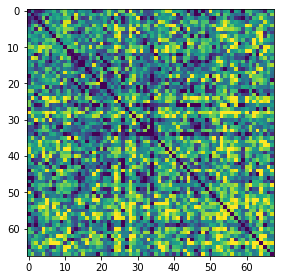

In [12]:
label_ts = mne.extract_label_time_course(stcs, labels, src, mode='mean_flip', return_generator=False)
corr = mne.connectivity.envelope_correlation(label_ts, verbose=True)

# let's plot this matrix
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
fig.tight_layout()

## Plot degrees using 3D backend

In [8]:
# threshold_prop = 0.15  # percentage of strongest edges to keep in the graph
# degree = mne.connectivity.degree(corr, threshold_prop=threshold_prop)
# stc = mne.labels_to_stc(labels, degree)
# stc = stc.in_label(mne.Label(inv['src'][0]['vertno'], hemi='lh') +
#                    mne.Label(inv['src'][1]['vertno'], hemi='rh'))
# brain = stc.plot(
#     clim=dict(kind='percent', lims=[75, 85, 95]), colormap='gnuplot',
#     views='dorsal', hemi='both',
#     smoothing_steps=25, time_label='Beta band')

In [17]:
fmin, fmax = 7.5, 40.0

_label_ts = [np.abs(e) for e in label_ts]

con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
    _label_ts, method='pli', mode='multitaper', sfreq=epochs.info['sfreq'],
    fmin=fmin, fmax=fmax, mt_adaptive=True, n_jobs=48)

Connectivity computation...
----- 0
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..1.400s for estimation (141 points)
    frequencies: 7.8Hz..39.7Hz (46 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..48


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    5.2s remaining:   17.6s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    5.3s remaining:    6.8s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    5.3s remaining:    2.9s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    5.3s remaining:    0.9s


----- 48
    computing connectivity for epochs 49..96


[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    5.5s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 96
    computing connectivity for epochs 97..144


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 144
    computing connectivity for epochs 145..192


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 192
    computing connectivity for epochs 193..240


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 240
    computing connectivity for epochs 241..288


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 288
    computing connectivity for epochs 289..336


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 336
    computing connectivity for epochs 337..384


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 384
    computing connectivity for epochs 385..432


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


----- 432
    computing connectivity for epochs 433..465


[Parallel(n_jobs=48)]: Done  11 out of  48 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  21 out of  48 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=48)]: Done  31 out of  48 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  41 out of  48 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=48)]: Done  48 out of  48 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


[Parallel(n_jobs=48)]: Done   7 out of  33 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  14 out of  33 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=48)]: Done  21 out of  33 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  28 out of  33 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=48)]: Done  33 out of  33 | elapsed:    0.2s finished


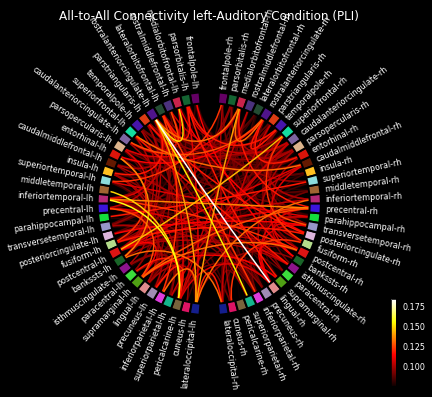

(<Figure size 576x576 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity left-Auditory Condition (PLI)'}>)

In [22]:
# We create a list of Label containing also the sub structures
subjects_dir = os.path.join('_link_freesurfer', 'subjects')
labels_aseg = mne.get_volume_labels_from_src(src, freesurfer_name, subjects_dir)
labels = labels + labels_aseg

# read colors
node_colors = [label.color for label in labels]

# We reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith('lh')]
rh_labels = [name for name in label_names if name.endswith('rh')]

# Get the y-location of the label
label_ypos_lh = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)
try:
    idx = label_names.index('Brain-Stem')
except ValueError:
    pass
else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append('Brain-Stem')
    label_ypos_lh.append(ypos)


# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels
             if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]

# Save the plot order
node_order = lh_labels[::-1] + rh_labels

node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) // 2])

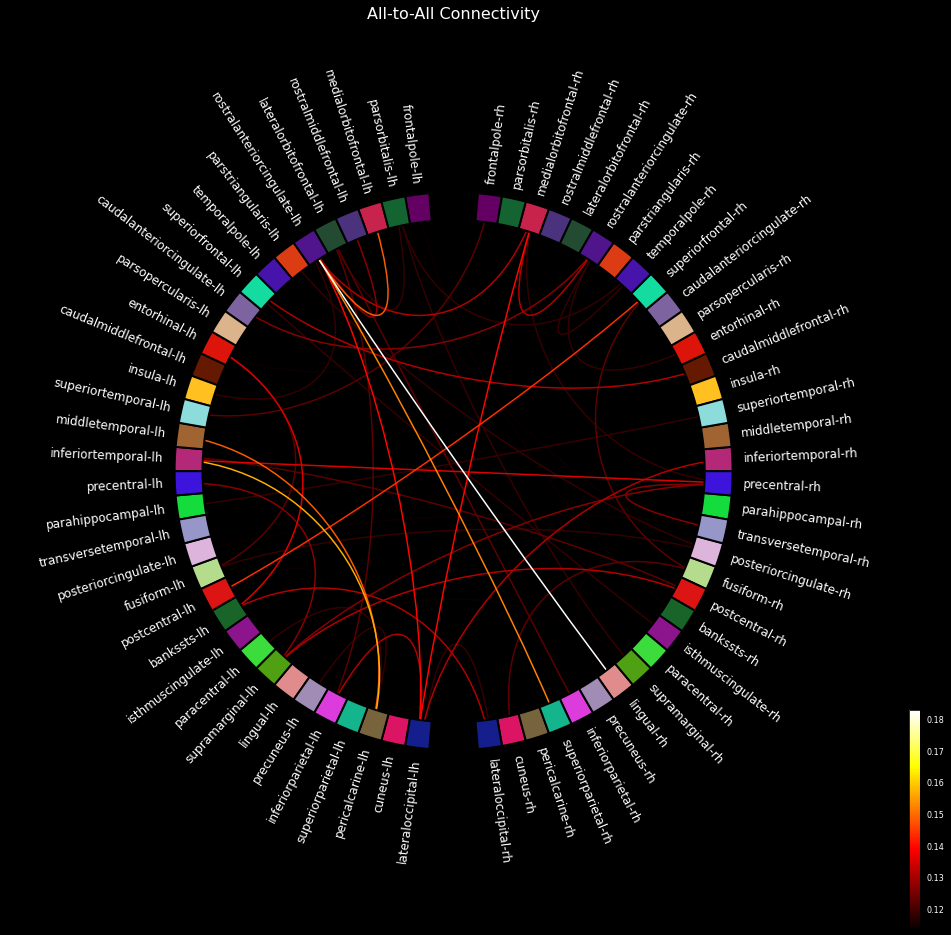

(<Figure size 1440x1440 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity'}>)

In [30]:
# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
conmat = con[:, :, 0]
fig = plt.figure(num=None, figsize=(20, 20), facecolor='black')
mne.viz.plot_connectivity_circle(conmat, label_names, n_lines=50,
                         node_angles=node_angles, node_colors=node_colors,
                         title='All-to-All Connectivity',
                         fontsize_title=16,
                         fontsize_names=12,
                         fig=fig)

In [26]:
help(plot_connectivity_circle)

Help on function plot_connectivity_circle in module mne.viz.circle:

plot_connectivity_circle(con, node_names, indices=None, n_lines=None, node_angles=None, node_width=None, node_colors=None, facecolor='black', textcolor='white', node_edgecolor='black', linewidth=1.5, colormap='hot', vmin=None, vmax=None, colorbar=True, title=None, colorbar_size=0.2, colorbar_pos=(-0.3, 0.1), fontsize_title=12, fontsize_names=8, fontsize_colorbar=8, padding=6.0, fig=None, subplot=111, interactive=True, node_linewidth=2.0, show=True)
    Visualize connectivity as a circular graph.
    
    Parameters
    ----------
    con : array
        Connectivity scores. Can be a square matrix, or a 1D array. If a 1D
        array is provided, "indices" has to be used to define the connection
        indices.
    node_names : list of str
        Node names. The order corresponds to the order in con.
    indices : tuple of array | None
        Two arrays with indices of connections for which the connections
        

In [34]:
d = np.array(label_ts)
d.shape

(465, 68, 141)

In [35]:
dir(d)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [36]:
help(d.tofile)

Help on built-in function tofile:

tofile(...) method of numpy.ndarray instance
    a.tofile(fid, sep="", format="%s")
    
    Write array to a file as text or binary (default).
    
    Data is always written in 'C' order, independent of the order of `a`.
    The data produced by this method can be recovered using the function
    fromfile().
    
    Parameters
    ----------
    fid : file or str or Path
        An open file object, or a string containing a filename.
    
        .. versionchanged:: 1.17.0
            `pathlib.Path` objects are now accepted.
    
    sep : str
        Separator between array items for text output.
        If "" (empty), a binary file is written, equivalent to
        ``file.write(a.tobytes())``.
    format : str
        Format string for text file output.
        Each entry in the array is formatted to text by first converting
        it to the closest Python type, and then using "format" % item.
    
    Notes
    -----
    This is a convenience f

In [44]:
np.save('d.npy', d, allow_pickle=True)